# Lecture des fichiers *rates* d'Apollo3 : le ``Reader``

La lecture des fichiers *rates* d'Apollo3 (réseau) est possible dans *valjean*, ainsi que les différents autres formats HDF5.

Deux modes de lecture sont possibles :

- lecture de tout le fichier HDF5 et stockage des résultats dans un `Browser`, récupération des résultats sous forme de `Dataset` grâce au `Browser` -> utilisation du `Reader`
- lecture d'un résultat ou de plusieurs résultats donnés à partir du HDF5 pour une utilisation directe sous forme de `Dataset` -> `Picker`

La seconde méthode est bien plus rapide car elle ne nécessite pas de charger l'intégralité du fichier et bénéficie des accès de lecture du HDF5.

Cet exemple se concentre sur la première méthode.

## Le `Reader` : résumé

In [1]:
from valjean.eponine.apollo3.hdf5_reader import Reader

Lecture d'un fichier *rates* typique : cas Mosteller, avec isotopes particularisés.

In [2]:
ap3r = Reader("full_rates.hdf")

* Reading full_rates.hdf
* hdf5 loading done in 0.046054 s
* Successful reading in 0.039481 s


Transformation en `Browser`

In [3]:
ap3b = ap3r.to_browser()

In [4]:
print(ap3b)

Browser object -> Number of content items: 39, data key: 'results', available metadata keys: ['index', 'isotope', 'output', 'result_name', 'zone']
               -> Number of globals: 2


39 = nombre de résultats total dans le fichier.

Il est possible de faire les deux précédentes étapes en une seule :

In [5]:
from valjean.eponine.apollo3.hdf5_reader import hdf_to_browser
htb = hdf_to_browser("full_rates.hdf")

* Reading full_rates.hdf
* hdf5 loading done in 0.002341 s
* Successful reading in 0.035396 s


## Inspection du fichier

On peut inspecter davantage le fichier grâce au `Browser` et connaître notamment les valeurs possibles des clefs du `Browser`.

In [6]:
print(f'isotopes: {list(ap3b.available_values("isotope"))}')
print(f'resultats: {list(ap3b.available_values("result_name"))}')
print(f'zones: {list(ap3b.available_values("zone"))}')
print(f'outputs: {list(ap3b.available_values("output"))}')

isotopes: ['TotalResidual_reduced_chain', 'I135', 'Sm149', 'U238', 'Xe135', 'macro']
resultats: ['concentration', 'flux', 'absorption', 'diffusion', 'nexcess', 'fission', 'fissionspectrum', 'nufission', 'total', 'current', 'keff', 'kinf', 'production', 'surfflux']
zones: ['q', 'totaloutput']
outputs: ['output_0']


Toutes les combinaisons ne sont pas possibles.

Pour sélectionner un résultat :

- si on ne sélectionne qu'un seul résultat : méthode `select_by` → dictionnaire correspondant au résultat demandé
- si on en sélectionne plusieurs en vue d'une sélection plus raffinée ensuite : `filter_by` → sous-`Browser` dont la liste de résultats a été réduite à ceux correspondant à la sélection demandée

Le résultat, sous forme de ``Dataset``, se trouve sous la clef ``'results'``.

In [7]:
sb_totout = ap3b.filter_by(zone='totaloutput')
print(sb_totout)
print(f'resultats: {list(sb_totout.available_values("result_name"))}')
print(f'outputs: {list(sb_totout.available_values("output"))}')

Browser object -> Number of content items: 7, data key: 'results', available metadata keys: ['index', 'output', 'result_name', 'zone']
               -> Number of globals: 2
resultats: ['absorption', 'current', 'flux', 'keff', 'kinf', 'production', 'surfflux']
outputs: ['output_0']


In [8]:
keffs = sb_totout.filter_by(result_name="keff")
print(len(keffs))

1


In [9]:
keff = sb_totout.select_by(result_name="keff")
print(keff)

{'result_name': 'keff', 'results': class: <class 'valjean.eponine.dataset.Dataset'>, data type: <class 'numpy.float32'>
value: 1.321053e+00, error:    nan, bins: OrderedDict()
name: '', what: 'keff'
, 'zone': 'totaloutput', 'output': 'output_0', 'index': 3}


In [10]:
sb_q = ap3b.filter_by(zone='q')
print(sb_q)

Browser object -> Number of content items: 32, data key: 'results', available metadata keys: ['index', 'isotope', 'output', 'result_name', 'zone']
               -> Number of globals: 2


In [11]:
print(f'isotopes: {list(sb_q.available_values("isotope"))}')
print(f'resultats: {list(sb_q.available_values("result_name"))}')
print(f'outputs: {list(sb_q.available_values("output"))}')

isotopes: ['TotalResidual_reduced_chain', 'I135', 'Sm149', 'U238', 'Xe135', 'macro']
resultats: ['concentration', 'flux', 'absorption', 'diffusion', 'nexcess', 'fission', 'fissionspectrum', 'nufission', 'total']
outputs: ['output_0']


In [12]:
sb_xe135 = sb_q.filter_by(isotope='Xe135')
print(f'resultats pour Xe135: {list(sb_xe135.available_values("result_name"))}')

resultats pour Xe135: ['concentration', 'absorption', 'diffusion']


In [13]:
sb_u238 = sb_q.filter_by(isotope='U238')
print(f'resultats pour U238: {list(sb_u238.available_values("result_name"))}')

resultats pour U238: ['concentration', 'absorption', 'diffusion', 'fission', 'fissionspectrum', 'nexcess', 'nufission']


## Sélection des résultats

La liste des résultats est disponible dans ``content`` dans le ``Browser`` ou directement grâce à la méthode ``select_by`` si la sélection est réduite à un résultat unique.

Les résultats sont sotckés sous la clef ``'results'`` sous forme de ``Dataset``.

La plupart des résultats sont donnés par groupes d'énergie. Les intervalles (`bins` dans le ``Dataset``) correspondent à l'index des groupes.

Certaines quantités ont différents axes :

- $k_{eff}$ et $k_{inf}$ : grandeurs scalaires, pas d'axes
- diffusion : le nombre d'anisotropies sur lequel le calcul est fait est pris en compte, s'il est différent de 1 les axes seront (anisotropies, groupes)
- flux surfacique : les axes sont (groupes, surfaces), surfaces contenant l'index des surfaces
- courant : les axes sont (groupes, surfaces, direction), surfaces contenant l'index des surfaces et direction (*incoming* et *leaving*)

In [14]:
xe135_abs = sb_q.select_by(isotope='Xe135', result_name='absorption')
print(list(xe135_abs.keys()))
xe135_abs = xe135_abs['results']
print(xe135_abs.shape)  # 26 groupes
print(xe135_abs.what)
xe135_abs.name = '$^{135}$Xe'

['result_name', 'results', 'isotope', 'zone', 'output', 'index']
(26,)
absorption


In [15]:
macro_diff = sb_q.select_by(isotope='macro', result_name='diffusion')
print(macro_diff['results'].what)
print(macro_diff['results'].shape)
print(list(macro_diff['results'].bins.keys()))

diffusion
(4, 26)
['anisotropies', 'groups']


In [16]:
surf_flux = sb_totout.select_by(result_name='surfflux')
print(surf_flux['results'].what)
print(surf_flux['results'].shape)
print(list(surf_flux['results'].bins.keys()))

surfflux
(26, 220)
['groups', 'surfaces']


In [17]:
current = sb_totout.select_by(result_name='current')['results']
print(current.what)
print(current.shape)
print(current.bins)

current
(26, 220, 2)
OrderedDict([('groups', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])), ('surfaces', array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 14

## Comparaison de résultats

Les tests disponibles dans *valjean* peuvent tout à fait être appliqués aux résultats issus du ``Reader`` ou du ``Picker``.

Ici `TestApproxEqual` : les résultats sont des `float` sans erreur associée (mise à `nan` par défaut).

### Import du test et des représentations (voir les autres notebooks)

In [18]:
from valjean.gavroche.test import TestApproxEqual
from valjean.javert.representation import FullRepresenter
from valjean.javert.rst import RstFormatter
from valjean.javert.mpl import MplPlot
from valjean.javert.verbosity import Verbosity

frepr = FullRepresenter()
rstformat = RstFormatter()

### Comparaison des aborptions pour différents isotopes

In [19]:
sm149_abs = sb_q.select_by(isotope='Sm149', result_name='absorption')['results']
sm149_abs.name = '$^{149}$Sm'
i135_abs = sb_q.select_by(isotope='I135', result_name='absorption')['results']
i135_abs.name = '$^{135}$I'

In [20]:
taeq_res = TestApproxEqual(xe135_abs, sm149_abs, i135_abs, name='TestApproxEqual',
                           description='Test le TestApproxEqual sur les absorptions', rtol=1e-2).evaluate()
print(bool(taeq_res))  # expected: False

False


Ajout d'une fonction pour passer en échelle logarithmique l'axe des ordonnées vu les variations du spectre.

In [21]:
from valjean.javert import plot_repr as pltr
def log_post(templates, tres):
    pltr.post_treatment(templates, tres)
    for templ in templates:
        templ.subplots[0].attributes.logy = True
    return templates

In [22]:
logaeqrepr = FullRepresenter(post=log_post)(taeq_res, verbosity=Verbosity.FULL_DETAILS)
aeqrst = rstformat.template(logaeqrepr[1])
print(aeqrst)

.. role:: hl

.. table::
    :widths: auto

    ======  ===========  ===========  =========================  ===========  ========================
    groups  $^{135}$Xe   $^{149}$Sm   approx equal($^{149}$Sm)?   $^{135}$I   approx equal($^{135}$I)?
    ======  ===========  ===========  =========================  ===========  ========================
         0      331.667      100.186                :hl:`False`      620.565               :hl:`False`
         1      635.539      1311.99                :hl:`False`      2837.33               :hl:`False`
         2      382.903      2705.19                :hl:`False`      1271.12               :hl:`False`
         3      1159.48      15132.2                :hl:`False`      1280.17               :hl:`False`
         4      1520.81      25141.5                :hl:`False`      1067.43               :hl:`False`
         5      1714.74      27434.2                :hl:`False`      1458.82               :hl:`False`
         6      2251.86      

/volatile/el220326/.venv/dev39/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


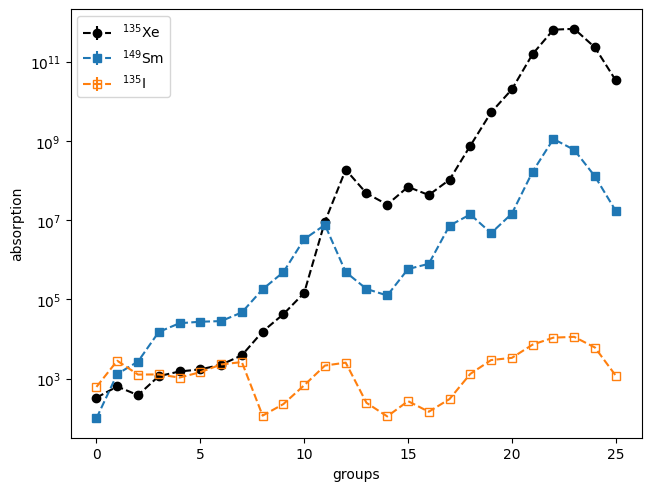

In [23]:
mpl = MplPlot(logaeqrepr[0]).draw()

### Comparaison de la diffusion pour les différentes valeurs d'anisotropie

La méthode `squeeze` permet de supprimer les dimensions triviales d'un `Dataset` (on ne comparera que des `Datasets` à une dimension ici).

In [24]:
macro_diff_aniso = [macro_diff['results'][:1, :].squeeze()]
macro_diff_aniso[-1].name = 'anisotropie = 0'
macro_diff_aniso[-1].what = 'diffusion (macro)'
print(macro_diff_aniso[-1])

shape: (26,), dim: 1, type: <class 'numpy.ndarray'>, bins: ['groups: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]'], name: anisotropie = 0, what: diffusion (macro)


In [25]:
# anisotropie d'ordre 1
macro_diff_aniso.append(macro_diff['results'][1:2, :].squeeze())
macro_diff_aniso[-1].name = 'anisotropie = 1'
macro_diff_aniso[-1].what = 'diffusion (macro)'
# anisotropie d'ordre 2
macro_diff_aniso.append(macro_diff['results'][2:3, :].squeeze())
macro_diff_aniso[-1].name = 'anisotropie = 2'
macro_diff_aniso[-1].what = 'diffusion (macro)'
# anisotropie d'ordre 3
macro_diff_aniso.append(macro_diff['results'][3:, :].squeeze())
macro_diff_aniso[-1].name = 'anisotropie = 3'
macro_diff_aniso[-1].what = 'diffusion (macro)'

In [26]:
taeq_res = TestApproxEqual(*macro_diff_aniso, name='TestApproxEqual',
                           description=("Test le TestApproxEqual sur la diffusion macroscopique aux différents "
                                        "ordres d'anisotropie"),
                           rtol=1e-2).evaluate()
print(bool(taeq_res))  # expected: False

False


In [27]:
aeqrepr = frepr(taeq_res, verbosity=Verbosity.FULL_DETAILS)  # il s'agit d'une liste de templates
aeqrst = rstformat.template(aeqrepr[1])
print(aeqrst)

.. role:: hl

.. table::
    :widths: auto

    ======  ===============  ===============  ==============================  ===============  ==============================  ===============  ==============================
    groups  anisotropie = 0  anisotropie = 1  approx equal(anisotropie = 1)?  anisotropie = 2  approx equal(anisotropie = 2)?  anisotropie = 3  approx equal(anisotropie = 3)?
    ======  ===============  ===============  ==============================  ===============  ==============================  ===============  ==============================
         0      3.03941e+13      1.43217e+13                     :hl:`False`      8.72864e+12                     :hl:`False`      5.80013e+12                     :hl:`False`
         1      2.12017e+14      9.70531e+13                     :hl:`False`      5.52561e+13                     :hl:`False`      2.46676e+13                     :hl:`False`
         2      2.12051e+14       8.9062e+13                     :hl:`False`     

/volatile/el220326/.venv/dev39/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


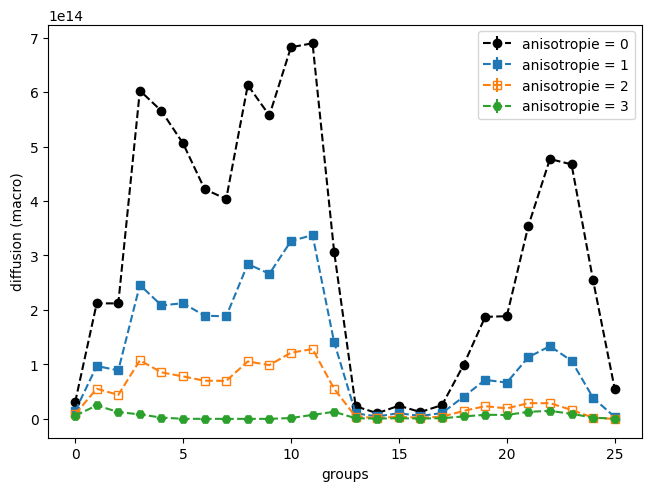

In [28]:
mpl = MplPlot(aeqrepr[0]).draw()

### Comparaison des courants entrants et sortants

Il s'agit d'une comparaison d'arrays en 2 dimensions, mais cela ne change pas les tests.

Pour une question de lisibilité du graphique on se restreint à 20 surfaces.

In [29]:
current_in = current[:, :20, :1].squeeze()
current_out = current[:, :20, 1:].squeeze()

In [30]:
caeq_res = TestApproxEqual(
    current_in, current_out, name='TestApproxEqual',
    description=("Test le TestApproxEqual sur la diffusion macroscopique aux différents "
                 "ordres d'anisotropie"),
    rtol=1e-2).evaluate()
print(bool(caeq_res))  # expected: False

False


In [31]:
caeqrepr = frepr(caeq_res, verbosity=Verbosity.FULL_DETAILS)  # il s'agit d'une liste de templates
caeqrst = rstformat.template(caeqrepr[1])
# print(caeqrst)

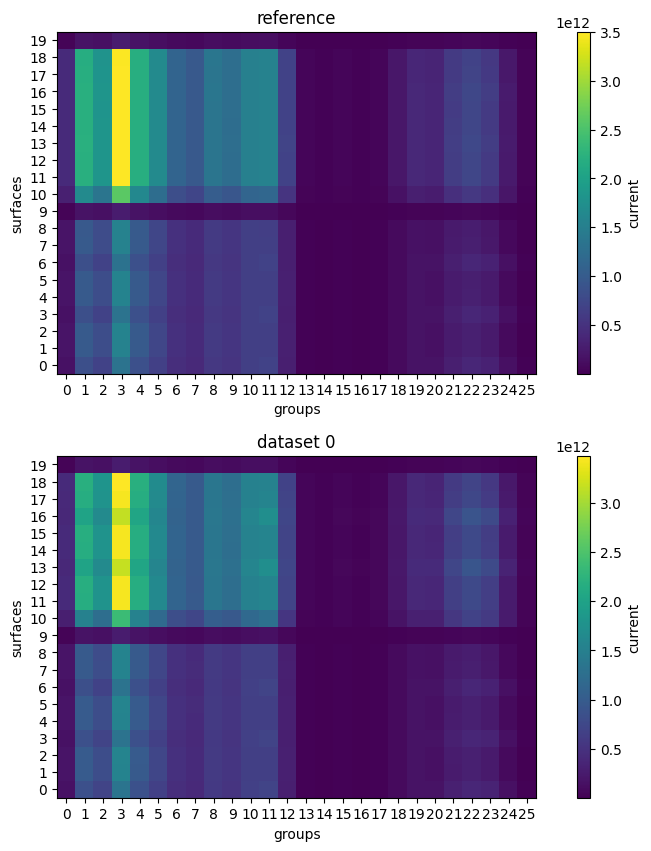

In [32]:
mpl = MplPlot(caeqrepr[0]).draw()

In [33]:
ratio = current_out / current_in

Text(0, 0.5, 'surfaces')

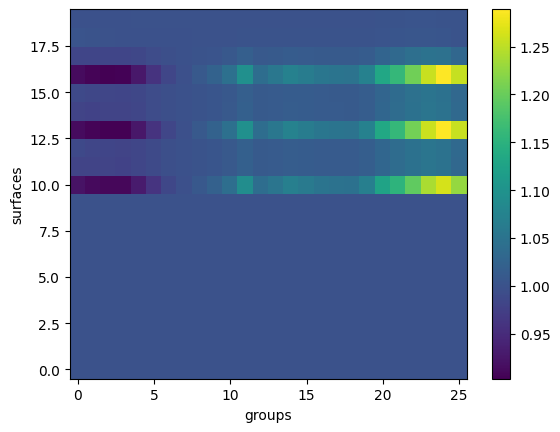

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, splts = plt.subplots()
bbins = np.broadcast_arrays(ratio.bins['groups'].reshape([26, 1]),
                            ratio.bins['surfaces'].reshape([20]))
h2d = splts.hist2d(
    bbins[0].flatten(), bbins[1].flatten(),
    bins=[np.append(ratio.bins['groups']-0.5, [ratio.bins['groups'][-1]+0.5]),
          np.append(ratio.bins['surfaces']-0.5, [ratio.bins['surfaces'][-1]+0.5])],
    weights=ratio.value.flatten())
cbar = fig.colorbar(h2d[3], ax=splts)
splts.set_xlabel('groups')
splts.set_ylabel('surfaces')